In [96]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import ViTModel, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [97]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [98]:
class FeatureDataset(Dataset):
    def __init__(self, feature_file):
        with open(feature_file, "rb") as f:
            self.data = pickle.load(f)
        self.video_names = list(self.data.keys())  # Store actual video names
        self.features = [torch.tensor(item[0], dtype=torch.float32) for item in self.data.values()]
        self.labels = [torch.tensor(item[1], dtype=torch.long) for item in self.data.values()]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.video_names[idx]  # Retur

In [99]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to("cuda")

# Function to extract and save features
def extract_features(video_folder, label,save_path, transform, frames_per_video=10,test_data=True):
    features_dict = {}
    videos = [os.path.join(video_folder, f) for f in os.listdir(video_folder)]
    with torch.no_grad():
        for video_path in tqdm(videos):
            video_name = os.path.basename(video_path)  # Get video filename
            cap = cv2.VideoCapture(video_path)
            frames = []
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            for _ in range(frames_per_video):
                frame_idx = np.random.randint(0, total_frames)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = transform(frame)
                    frames.append(frame)
            cap.release()

            if len(frames) < frames_per_video:
                frames.extend([frames[-1]] * (frames_per_video - len(frames)))  # Repeat last frame if needed

            frames_tensor = torch.stack(frames).to("cuda")
            features = vit_model(frames_tensor.flatten(0,1))["last_hidden_state"][:, 0, :]
            features_dict[video_name] = (features.cpu().numpy(), label)  # Store video name

    with open(save_path, "wb") as f:
        pickle.dump(features_dict, f)
    if(test_data==True):
        with open("test_features.pkl", "rb") as f:
            test_features = pickle.load(f)

        # Load actual video filenames in order
        test_videos = sorted(os.listdir("/content/drive/MyDrive/Dataset/Test/Brawl_test")) + sorted(os.listdir("/content/drive/MyDrive/Dataset/Test/Peace_test"))

        # Ensure video count matches features count
        assert len(test_videos) == len(test_features), "Mismatch between video count and stored features!"

        # Manually assign correct names
        video_mapping = {idx: test_videos[idx] for idx in range(len(test_videos))}

        # Replace numeric keys with filenames
        corrected_features = {video_mapping[idx]: value for idx, value in test_features.items()}

        # Save corrected test features
        with open("test_features_corrected.pkl", "wb") as f:
            pickle.dump(corrected_features, f)

        print("Corrected test_features.pkl saved with video names!")

# Extract and save features only if they don't exist
if not os.path.exists("train_features.pkl"):
    extract_features("dataset/Brawl", 1, "train_features.pkl", transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))
    extract_features("dataset/Peace", 0, "train_features.pkl", transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))

if not os.path.exists("test_features_corrected.pkl"):
    extract_features("test/Brawl", 1, "test_features.pkl", transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),test_data=True)
    extract_features("test/Peace", 0, "test_features.pkl", transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ],test_data=True))

# Load datasets
dataset_train = FeatureDataset("train_features.pkl")
dataset_test = FeatureDataset("test_features_corrected.pkl")

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [100]:
# Ensure DataLoader workers have a fixed seed
def seed_worker(worker_id):
    np.random.seed(seed)
    torch.manual_seed(seed)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, worker_init_fn=seed_worker, generator=g)

In [101]:
# BiLSTM Model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, output_dim=2):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden)


In [102]:
# Load trained model
model = BiLSTMClassifier().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [103]:
# Training
for epoch in range(10):
    model.train()
    for features, labels, _ in tqdm(train_loader):
        features, labels = features.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


100%|██████████| 200/200 [00:00<00:00, 284.41it/s]


Epoch 1, Loss: 0.014240346848964691


100%|██████████| 200/200 [00:00<00:00, 285.28it/s]


Epoch 2, Loss: 0.04164709150791168


100%|██████████| 200/200 [00:00<00:00, 291.79it/s]


Epoch 3, Loss: 0.05074911564588547


100%|██████████| 200/200 [00:00<00:00, 294.41it/s]


Epoch 4, Loss: 0.012126734480261803


100%|██████████| 200/200 [00:00<00:00, 285.93it/s]


Epoch 5, Loss: 0.0006554242572747171


100%|██████████| 200/200 [00:00<00:00, 290.00it/s]


Epoch 6, Loss: 0.012302071787416935


100%|██████████| 200/200 [00:00<00:00, 293.45it/s]


Epoch 7, Loss: 0.0033094934187829494


100%|██████████| 200/200 [00:00<00:00, 289.74it/s]


Epoch 8, Loss: 3.0069528293097392e-05


100%|██████████| 200/200 [00:00<00:00, 285.43it/s]


Epoch 9, Loss: 1.965420597116463e-05


100%|██████████| 200/200 [00:00<00:00, 292.47it/s]

Epoch 10, Loss: 0.004123910330235958


In [104]:
# Evaluation and saving predictions
model.eval()
y_true, y_pred = [], []
predictions_list = []

with torch.no_grad():
    for features, labels, video_names in tqdm(test_loader):
        features = features.to("cuda")
        outputs = model(features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

        # Save Video Name + Boolean Prediction
        for video, pred in zip(video_names, predictions):
            predictions_list.append({"video_id": video, "brawl": bool(pred)})

# Compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Save predictions to CSV (With Correct Video Names


100%|██████████| 50/50 [00:00<00:00, 1024.83it/s]

Test Accuracy: 0.9475, F1 Score: 0.9479


In [105]:
# Save predictions to CSV (With Correct Video Names)
predictions_df = pd.DataFrame(predictions_list)
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv!")


Predictions saved to predictions.csv!


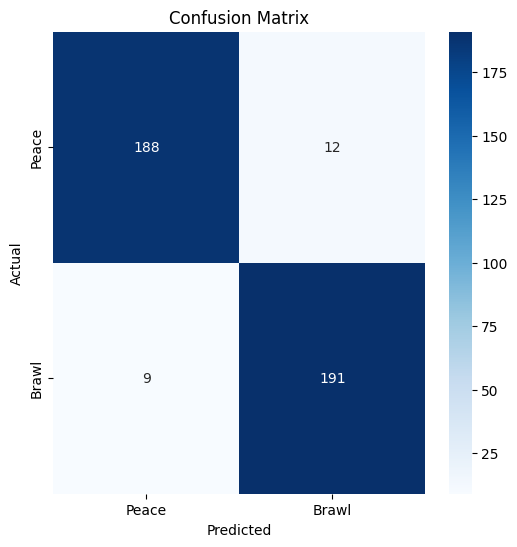

In [106]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Peace", "Brawl"], yticklabels=["Peace", "Brawl"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()